In [79]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error # 0.3 error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_columns',None)
import seaborn as sns

In [3]:
# Reading csv file
df = pd.read_csv('dataset/googleplaystore.csv')

In [4]:
df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


# Data Cleaning
With that being said, here are the various steps taken to clean the data:

In [5]:
# Data cleaning for "Size" column
df['Size'] = df['Size'].map(lambda x: x.rstrip('M'))
df['Size'] = df['Size'].map(lambda x: str(round((float(x.rstrip('k'))/1024), 1)) if x[-1]=='k' else x)
df['Size'] = df['Size'].map(lambda x: np.nan if x.startswith('Varies') else x)
# Data cleaning for "Installs" column
df['Installs'] = df['Installs'].map(lambda x: x.rstrip('+'))
df['Installs'] = df['Installs'].map(lambda x: ''.join(x.split(',')))
# Data cleaning for "Price" column
df['Price'] = df['Price'].map(lambda x: x.lstrip('$').rstrip())
# Row 10472 removed due to missing value of Category
df.drop(df.index[10472], inplace=True)
# Row [7312,8266] removed due to "Unrated" value in Content Rating
df.drop(df.index[[7312,8266]], inplace=True)

In [6]:
# Sort by "Category"
df.sort_values("Category", inplace = True)

The current dataset holds values that are in the string format. For solving a regression problem, we should convert the strings to a numerical format. To do so, we will proceed as follows:

In [7]:
# Label encoding
lb_make = LabelEncoder()
# Create column for "numeric" Content Rating 
df["Content Rating NUM"] = lb_make.fit_transform(df["Content Rating"])
# Form dicitonary for Content Rating and numeric values 
dict_content_rating = {"Adults only 18+": 0, "Everyone": 1, "Everyone 10+": 2, "Mature 17+": 3, "Teen": 4}

In [ ]:
# Numeric value for Content Rating
'''
Adults only 18+ = 0
Everyone = 1
Everyone 10+ = 2
Mature 17+ = 3
Teen = 4
'''

In [8]:
# Create column for "numeric" Category
df["Category NUM"] = lb_make.fit_transform(df["Category"])
# Form dicitonary for Category and numeric values
dict_category = {}
val = 0
for i in df["Category"].unique():
 dict_category[i] = val
 val += 1

In [10]:
dict_category

{'ART_AND_DESIGN': 0,
 'AUTO_AND_VEHICLES': 1,
 'BEAUTY': 2,
 'BOOKS_AND_REFERENCE': 3,
 'BUSINESS': 4,
 'COMICS': 5,
 'COMMUNICATION': 6,
 'DATING': 7,
 'EDUCATION': 8,
 'ENTERTAINMENT': 9,
 'EVENTS': 10,
 'FAMILY': 11,
 'FINANCE': 12,
 'FOOD_AND_DRINK': 13,
 'GAME': 14,
 'HEALTH_AND_FITNESS': 15,
 'HOUSE_AND_HOME': 16,
 'LIBRARIES_AND_DEMO': 17,
 'LIFESTYLE': 18,
 'MAPS_AND_NAVIGATION': 19,
 'MEDICAL': 20,
 'NEWS_AND_MAGAZINES': 21,
 'PARENTING': 22,
 'PERSONALIZATION': 23,
 'PHOTOGRAPHY': 24,
 'PRODUCTIVITY': 25,
 'SHOPPING': 26,
 'SOCIAL': 27,
 'SPORTS': 28,
 'TOOLS': 29,
 'TRAVEL_AND_LOCAL': 30,
 'VIDEO_PLAYERS': 31,
 'WEATHER': 32}

In [9]:
# Replace "NaN" with mean 
imputer = SimpleImputer()
df['Rating'] = imputer.fit_transform(df[['Rating']])
# Rounding the mean value to 1 decimal place
df['Rating'].round(1)
df.dropna(axis=0, inplace=True)

In [10]:
# Change datatype
df['Reviews'] = pd.to_numeric(df['Reviews'])
df['Installs'] = pd.to_numeric(df['Installs'])
df['Price'] = pd.to_numeric(df['Price'])

In [ ]:
Problem Statement:
To predict the ratings of the App (before/after launching it on Play Store).

This is clearly a regression problem.

In [ ]:
The factors that require attention in solving this problem are,

1) Category

2) Reviews

3) Size

4) Installs

5) Price

6) Content Rating

Here, Category and Content Rating are categorical values. So instead of these, we will use “Category NUM” 
and “Content Rating NUM” that contains a numerical mapping.

By taking the values of these columns into the account, we will get a prediction for “Rating” of the app. 
The rating can be obtained by providing the current values and comparing the predicted value and original 
value to get an overview of whether the app is performing better or worse than expected.

In [11]:
# Features selection
features = ['Category NUM', 'Reviews', 'Size', 'Installs', 'Price', 'Content Rating NUM']
X = df[features]
# Label selection
y = df.Rating
# For testing purpose
train_X, test_X, train_y, test_y = train_test_split(X, y)

In [ ]:
Machine Learning Model:
The model used to train the dataset is the “Random Forest Regressor”.

In [71]:
from sklearn.metrics import accuracy_score
import math
# Loop is used to get more generalized result
total_sum = []
accuracy1=[]
for i in range(10):
 # Hypertuning of parameters for better prediction
 forest_model = RandomForestRegressor(n_estimators=100, max_features=3, min_samples_leaf=10)
 #forest_model.fit(X, y)
 # For testing purpose
 forest_model.fit(train_X, train_y)
 # Pass values to get prediction for ratings
 # 1st value = Category NUM
 # 2nd value = Reviews
 # 3rd value = Size
 # 4th value = Installs
 # 5th value = Price
 # 6th value = Content Rating NUM
 #forest_pred = forest_model.predict([[4,100000,20,1000000,5,1]])
 #total_sum.append(forest_pred)
 
 # For testing purpose
 forest_pred = forest_model.predict(test_X)
 #print(forest_pred)
 #accuracy = forest_model.score(test_X,test_y)
 #print( 'Random Forest Regressor Accuracy: ', accuracy*100,'%')
 
 #accuracy=forest_model.score(test_y, forest_pred)   
 mse=(mean_absolute_error(forest_pred, test_y))
 rmse = math.sqrt(mse)
 accuracy1.append(100*max(0,rmse))   
 print('Accuracy for Random Forest',100*max(0,rmse))
  

Accuracy for Random Forest 54.448175372766705
Accuracy for Random Forest 54.537568435786795
Accuracy for Random Forest 54.51271366958452
Accuracy for Random Forest 54.62220299768526
Accuracy for Random Forest 54.47632028698535
Accuracy for Random Forest 54.498991292628986
Accuracy for Random Forest 54.45468152498207
Accuracy for Random Forest 54.65671026228163
Accuracy for Random Forest 54.5639879935171
Accuracy for Random Forest 54.61345152360255


In [72]:
print('Accuracy for Random Forest')
print(round(np.median(accuracy1), 2))

Accuracy for Random Forest
54.53


In [15]:
#forest_pred = forest_model.predict([[1,159,19,10000,0.0,1]])
#total_sum.append(forest_pred)

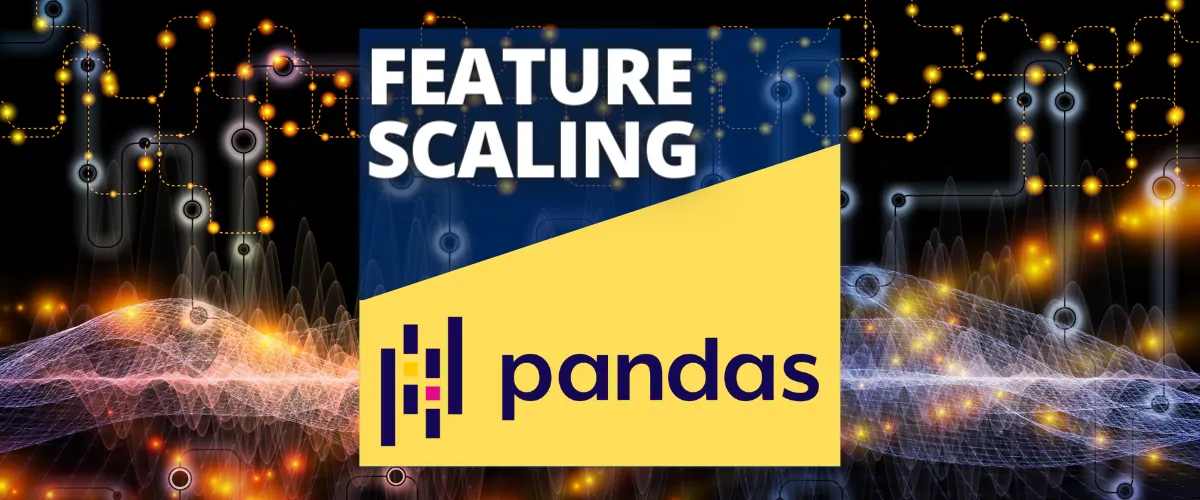

<AxesSubplot:>

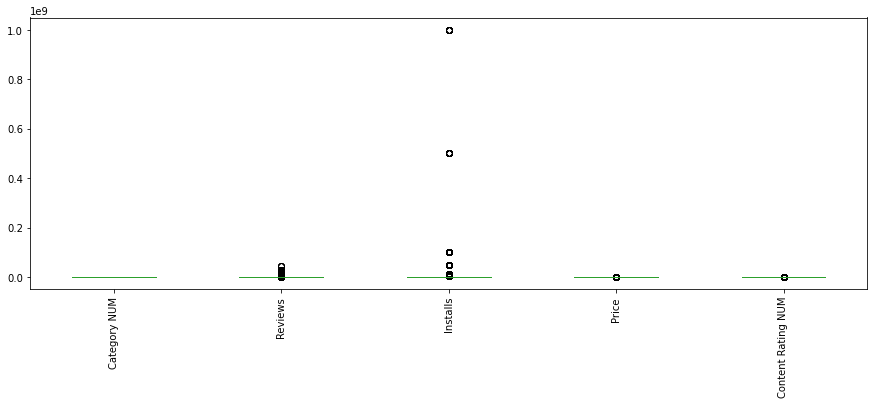

In [22]:
train_X.plot.box(figsize=(15,5), rot=90)

In [ ]:
Normalization
Normalization transforms data into the same range.

MinMaxScaler Transform features by scaling each feature to a given range.
MinMaxScaler().fit(train_X) is used to create a scaler.
Notice: We only do it on training data

In [ ]:
Feature Scaling Techniques
Normalization is a special case of MinMaxScaler
Normalization: Converts values between 0-1(values - values.min())/(values.max() - values.min())
MinMaxScaler: Between any values
Standardization (StandardSclaer from sklearn)
Mean: 0, StdDev: 1(values - values.mean())/values.std()
Less sensitive to outliers

<AxesSubplot:>

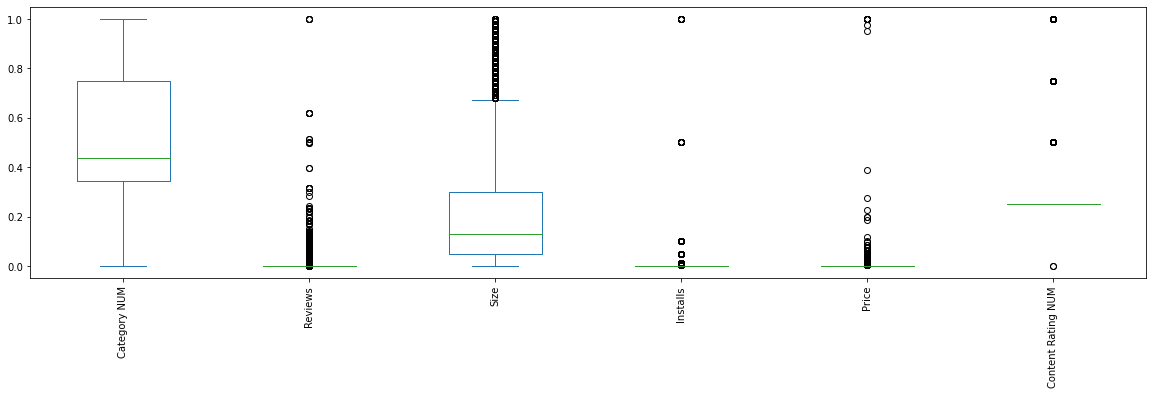

In [24]:
from sklearn.preprocessing import MinMaxScaler
norm = MinMaxScaler().fit(train_X)
X_train_norm = norm.transform(train_X)
X_test_norm = norm.transform(test_X)
pd.DataFrame(X_train_norm, columns=train_X.columns).plot.box(figsize=(20,5), rot=90)

In [ ]:
Standardization
StandardScaler Standardize features by removing the mean and scaling to unit variance.

<AxesSubplot:>

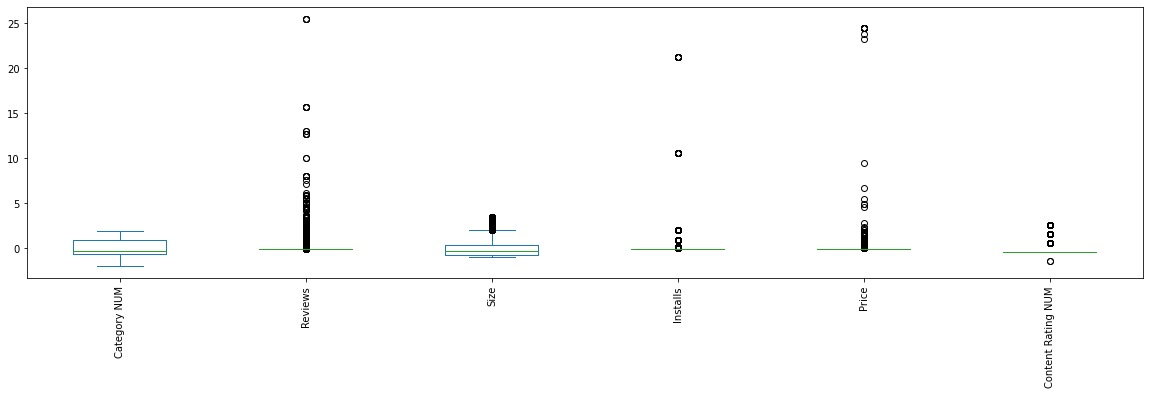

In [25]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler().fit(train_X)
X_train_stand = scale.transform(train_X)
X_test_stand = scale.transform(test_X)
pd.DataFrame(X_train_stand, columns=train_X.columns).plot.box(figsize=(20,5), rot=90)

In [73]:
from sklearn.metrics import accuracy_score
import math
# Loop is used to get more generalized result
total_sum = []
accuracy1=[]
for i in range(10):
 # Hypertuning of parameters for better prediction
 forest_model = LinearRegression()
 #forest_model = RandomForestRegressor(n_estimators=100, max_features=3, min_samples_leaf=10)
 #forest_model.fit(X, y)
 # For testing purpose
 forest_model.fit(X_train_norm, train_y)
 # Pass values to get prediction for ratings
 # 1st value = Category NUM
 # 2nd value = Reviews
 # 3rd value = Size
 # 4th value = Installs
 # 5th value = Price
 # 6th value = Content Rating NUM
 #forest_pred = forest_model.predict([[4,100000,20,1000000,5,1]])
 #total_sum.append(forest_pred)
 
 # For testing purpose
 forest_pred = forest_model.predict(X_test_norm)
 #print(forest_pred)
 #accuracy = forest_model.score(test_X,test_y)
 #print( 'Random Forest Regressor Accuracy: ', accuracy*100,'%')
 
 #accuracy=forest_model.score(test_y, forest_pred)   
 mse=(mean_absolute_error(forest_pred, test_y))
 rmse = math.sqrt(mse)
 accuracy1.append(100*max(0,rmse))   
 print('Accuracy for LinearRegression',100*max(0,rmse))


Accuracy for LinearRegression 56.783996441332754
Accuracy for LinearRegression 56.783996441332754
Accuracy for LinearRegression 56.783996441332754
Accuracy for LinearRegression 56.783996441332754
Accuracy for LinearRegression 56.783996441332754
Accuracy for LinearRegression 56.783996441332754
Accuracy for LinearRegression 56.783996441332754
Accuracy for LinearRegression 56.783996441332754
Accuracy for LinearRegression 56.783996441332754
Accuracy for LinearRegression 56.783996441332754


In [74]:
print('Accuracy for LinearRegression')
print(round(np.median(accuracy1), 2))

Accuracy for LinearRegression
56.78


In [66]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [64]:
random_grid={'bootstrap': [True, False],
 'max_depth': [70],
 'max_features': ['auto'],
 'min_samples_leaf': [4],
 'min_samples_split': [10],
 'n_estimators': [400]}

In [75]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import math
# Loop is used to get more generalized result
total_sum = []
accuracy1=[]
for i in range(10):
 # Hypertuning of parameters for better prediction
 #forest_model = RandomForestRegressor(n_estimators=100, max_features=5, min_samples_leaf=10)
 #forest_model.fit(X, y)
 # For testing purpose
 #forest_model.fit(X_train_stand, train_y)
 forest_model = LinearRegression()
 #rf_random = RandomizedSearchCV(estimator = forest_model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
 forest_model.fit(X_train_stand, train_y)
 # Pass values to get prediction for ratings
 # 1st value = Category NUM
 # 2nd value = Reviews
 # 3rd value = Size
 # 4th value = Installs
 # 5th value = Price
 # 6th value = Content Rating NUM
 #forest_pred = forest_model.predict([[4,100000,20,1000000,5,1]])
 #total_sum.append(forest_pred)
 
 # For testing purpose
 forest_pred =forest_model.predict(X_test_stand)
 #print(forest_pred)
 #accuracy = forest_model.score(test_X,test_y)
 #print( 'Random Forest Regressor Accuracy: ', accuracy*100,'%')
 
 #accuracy=forest_model.score(test_y, forest_pred)   
 mse=(mean_absolute_error(forest_pred, test_y))
 rmse = math.sqrt(mse)
 accuracy1.append(100*max(0,rmse))   
 print('Accuracy for LinearRegression',100*max(0,rmse))

Accuracy for LinearRegression 56.78399644133276
Accuracy for LinearRegression 56.78399644133276
Accuracy for LinearRegression 56.78399644133276
Accuracy for LinearRegression 56.78399644133276
Accuracy for LinearRegression 56.78399644133276
Accuracy for LinearRegression 56.78399644133276
Accuracy for LinearRegression 56.78399644133276
Accuracy for LinearRegression 56.78399644133276
Accuracy for LinearRegression 56.78399644133276
Accuracy for LinearRegression 56.78399644133276


In [76]:
print('Accuracy for Random Forest')
print(round(np.median(accuracy1), 2))

Accuracy for Random Forest
56.78


In [61]:
df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Content Rating NUM,Category NUM
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,1,0
35,How to draw Ladybug and Cat Noir,ART_AND_DESIGN,3.8,564,9.2,100000,Free,0.0,Everyone,Art & Design,"July 11, 2018",2.1,4.1 and up,1,0
36,UNICORN - Color By Number & Pixel Art Coloring,ART_AND_DESIGN,4.7,8145,24,500000,Free,0.0,Everyone,Art & Design;Creativity,"August 2, 2018",1.0.9,4.4 and up,1,0
38,PIP Camera - PIP Collage Maker,ART_AND_DESIGN,4.7,158,11,10000,Free,0.0,Everyone,Art & Design,"November 29, 2017",1.3,4.0.3 and up,1,0
39,How To Color Disney Princess - Coloring Pages,ART_AND_DESIGN,4.0,591,9.4,500000,Free,0.0,Everyone,Art & Design,"March 31, 2018",1,4.0 and up,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3636,Weather –Simple weather forecast,WEATHER,4.4,40606,15,10000000,Free,0.0,Everyone,Weather,"August 5, 2018",v7.0.02.3.0516.1_06_0713,5.0 and up,1,32
5659,Au Weather Free,WEATHER,4.0,1185,5.0,100000,Free,0.0,Everyone,Weather,"June 18, 2018",2.47.2,2.3 and up,1,32
3634,Free live weather on screen,WEATHER,4.4,15370,21,1000000,Free,0.0,Everyone,Weather,"August 2, 2018",12.2.6.3660,4.1 and up,1,32
8168,Windguru Lite,WEATHER,4.0,9307,5.0,1000000,Free,0.0,Everyone,Weather,"January 9, 2018",2.0.8,4.4 and up,1,32


<AxesSubplot:>

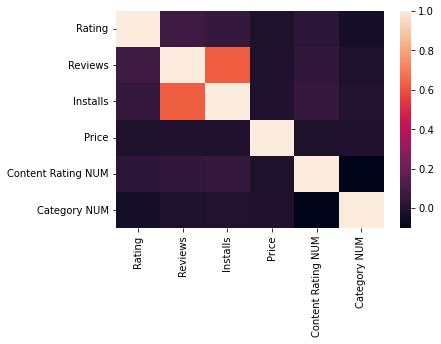

In [80]:
#Correlation plot

sns.heatmap(df.corr())